# Heart Attack Prediction & Analysis Notebook

This notebook performs the following steps:

1. Data Preprocessing
2. Exploratory Data Analysis (EDA)
3. Train-test Split (with stratification)
4. Handling Imbalance using SMOTE
5. Training Models:
    - Logistic Regression
    - Random Forest
    - XGBoost
    - Support Vector Machine (SVM)
6. Evaluating Models with Accuracy, Precision, Recall, F1-Score, ROC-AUC, and Confusion Matrix
7. Hyperparameter Tuning for Random Forest and XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Modeling tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# XGBoost Model
import xgboost as xgb

# For warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load the Dataset

We load the dataset from a CSV file.

In [2]:
data = pd.read_csv('Medicaldataset.csv')
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (1319, 9)


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,63,1,66,160,83,160.0,1.80,0.012,negative
1,20,1,94,98,46,296.0,6.75,1.060,positive
2,56,1,64,160,77,270.0,1.99,0.003,negative
3,66,1,70,120,55,270.0,13.87,0.122,positive
4,54,1,64,112,65,300.0,1.08,0.003,negative


## 2. Data Preprocessing

- **Missing Values:** We check for any missing values.
- **Target Conversion:** We ensure that the target variable (assumed here to be named `target`) is binary (0/1).

In [3]:
print("Missing values per column:")
print(data.isnull().sum())

if 'Result' in data.columns:
    data['Result'] = data['Result'].map({'positive': 1, 'negative': 0})

if 'Result' not in data.columns:
    print("Please check the column names. Available columns:", data.columns)
else:
    print("Value counts for target:")
    print(data['Result'].value_counts())

data.head()

Missing values per column:
Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64
Value counts for target:
Result
1    810
0    509
Name: count, dtype: int64


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,63,1,66,160,83,160.0,1.80,0.012,0
1,20,1,94,98,46,296.0,6.75,1.060,1
2,56,1,64,160,77,270.0,1.99,0.003,0
3,66,1,70,120,55,270.0,13.87,0.122,1
4,54,1,64,112,65,300.0,1.08,0.003,0


## 3. Exploratory Data Analysis (EDA)

We explore the dataset with:
- A count plot to visualize the class distribution.
- A correlation heatmap to understand feature relationships.

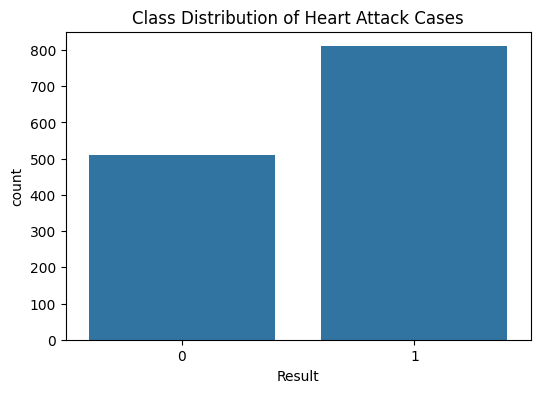

In [4]:
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Result', data=data)
plt.title('Class Distribution of Heart Attack Cases')
plt.show()

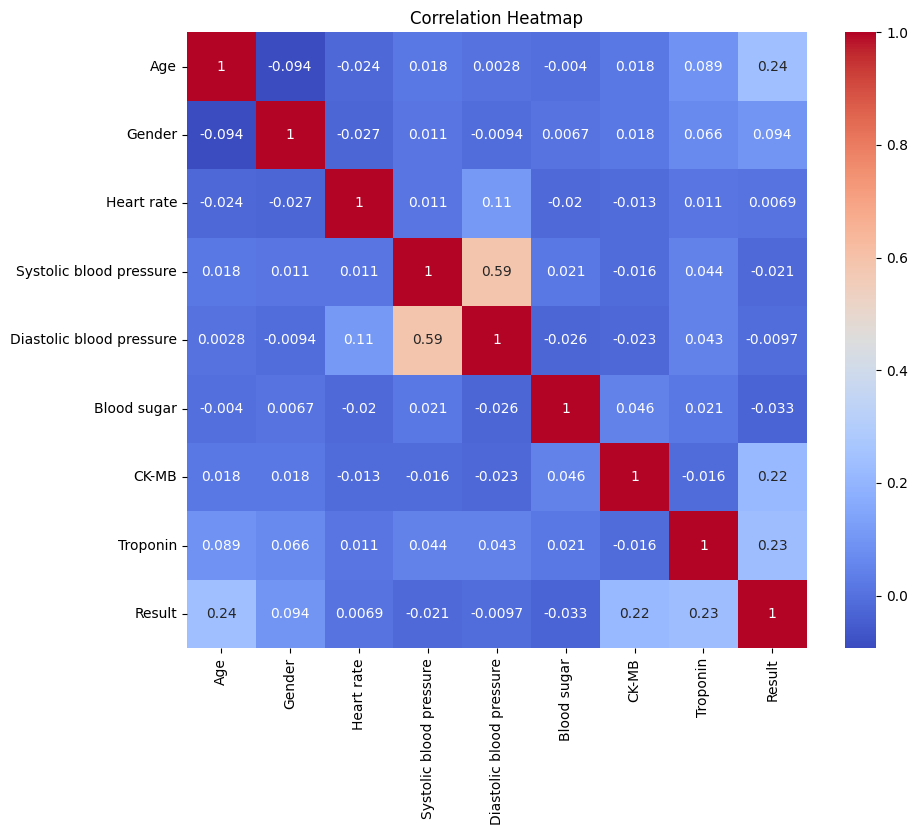

In [5]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Splitting the Data & Handling Imbalance

- We separate the features (X) and the target (y).
- We split the data into training and testing sets using stratification to maintain class distribution.
- Then, we apply SMOTE to the training data to balance the classes.

In [6]:
# Separate features and target
X = data.drop('Result', axis=1)
y = data['Result']

# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1055, 8)
Test set shape: (264, 8)


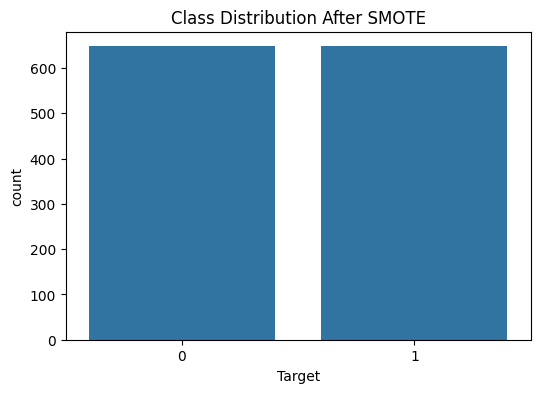

After SMOTE, training set shape: (1296, 8)
Class distribution after SMOTE: [648 648]


In [7]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Convert to DataFrame for plotting
smote_df = pd.DataFrame({'Target': y_train_sm})

# Plot distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=smote_df, x='Target')
plt.title('Class Distribution After SMOTE')
plt.show()

print("After SMOTE, training set shape:", X_train_sm.shape)
print("Class distribution after SMOTE:", np.bincount(y_train_sm))

## 5. Model Training & Evaluation

We will train the following models:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. Support Vector Machine (SVM)

A helper function is defined below to evaluate each model.

In [8]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Model Evaluation: {model_name}", fontsize=16)

    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title("Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    ax[1].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title("ROC Curve")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].legend()

    # Metrics Table
    metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
        'Score': [acc, prec, rec, f1, roc_auc]
    })
    ax[2].axis('off')
    table = ax[2].table(cellText=metrics.values,
                        colLabels=metrics.columns,
                        loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    ax[2].set_title("Evaluation Metrics Table", fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_feature_importance(name, model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # Top N features
    plt.figure(figsize=(8, 5))
    plt.title(f"{name} - Top Feature Importances")
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()


### 5.1 Logistic Regression

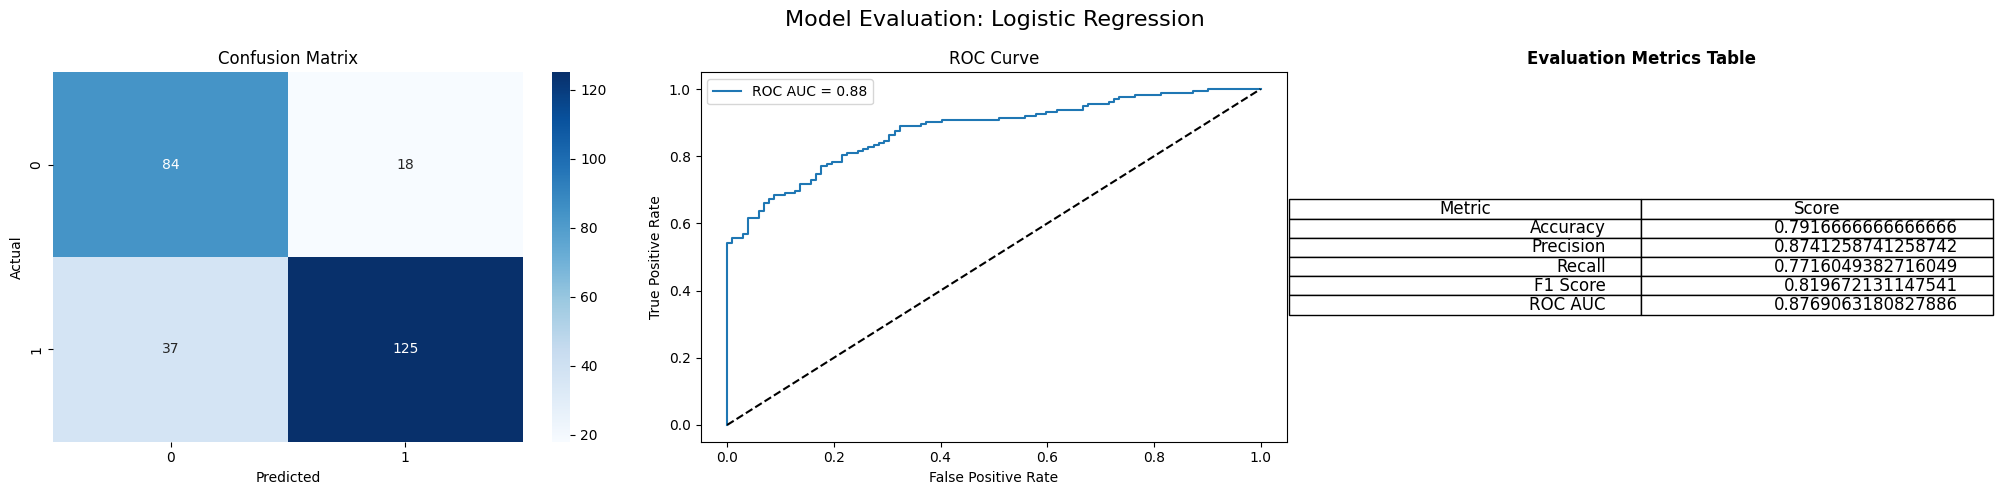

In [9]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_sm, y_train_sm)
evaluate_model(lr, X_test, y_test, "Logistic Regression")

### 5.2 Random Forest

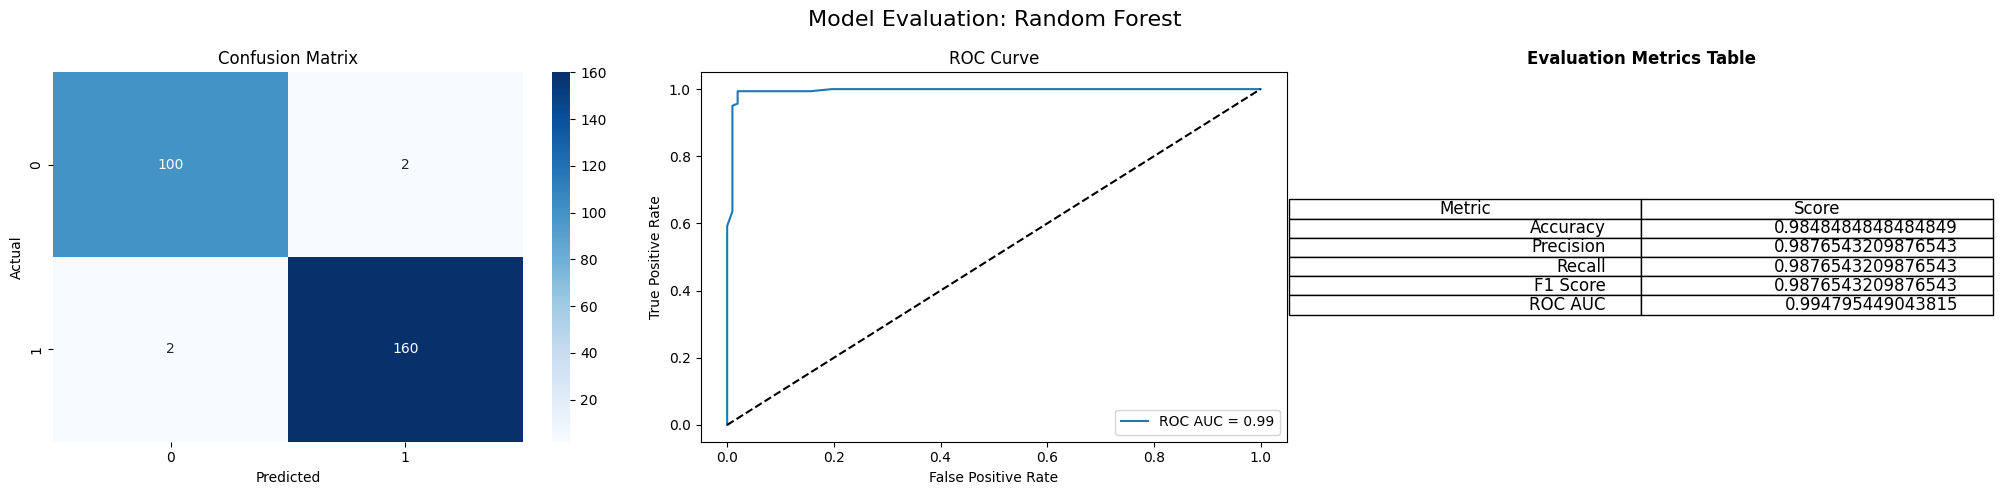

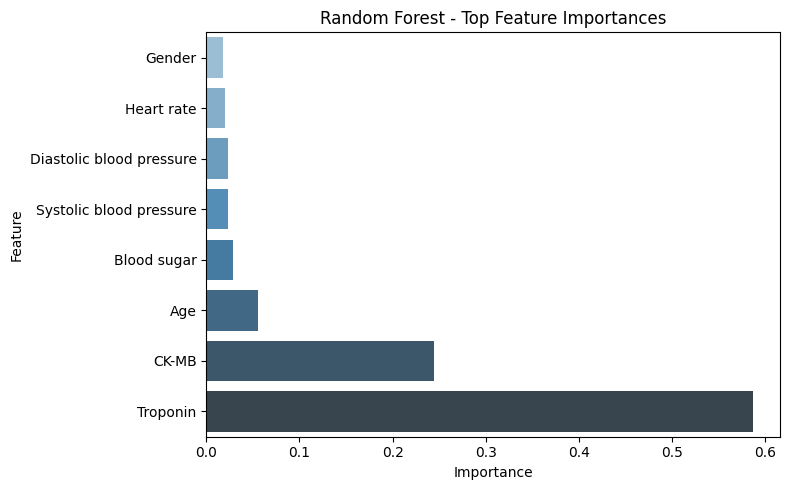

In [10]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_sm, y_train_sm)
evaluate_model(rf, X_test, y_test, "Random Forest")
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top N features

# Create DataFrame for nicer plotting
importance_df = pd.DataFrame({
    'Feature': [X_train_sm.columns[i] for i in indices],
    'Importance': importances[indices]
}).sort_values(by='Importance')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='Blues_d')
plt.title('Random Forest - Top Feature Importances')
plt.tight_layout()
plt.show()

### 5.3 XGBoost

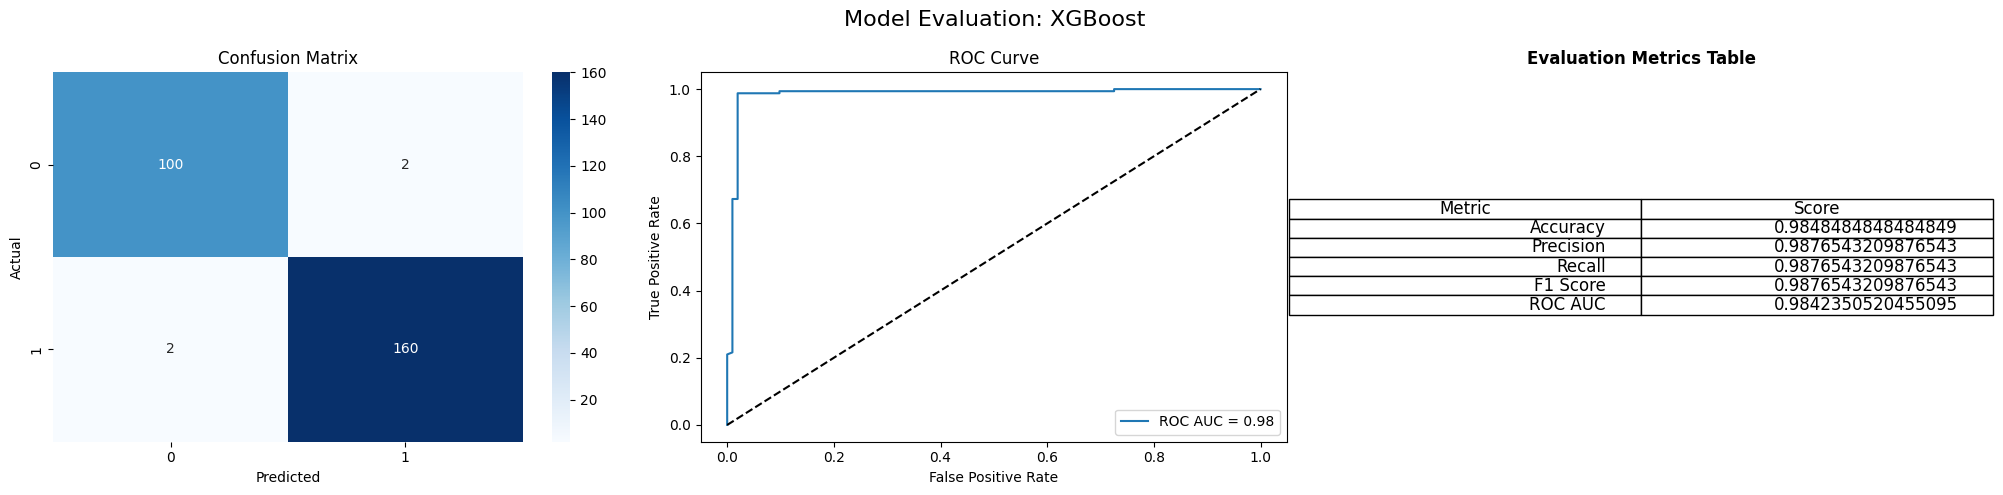

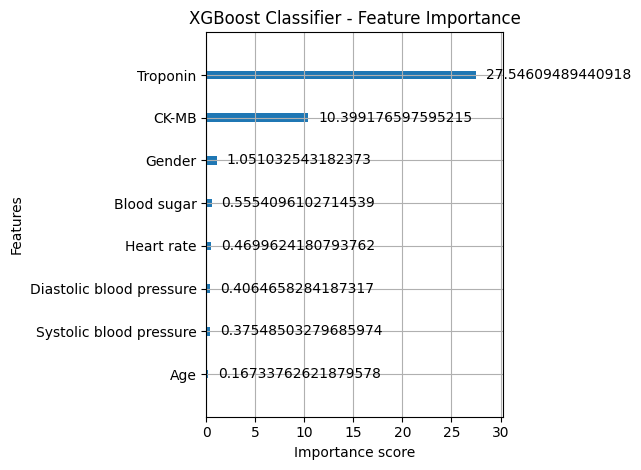

In [11]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_sm, y_train_sm)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")
xgb.plot_importance(xgb_model, importance_type="gain")
plt.title("XGBoost Classifier - Feature Importance")
plt.tight_layout()
plt.show()

### 5.4 Support Vector Machine (SVM)

Note: We set `probability=True` to enable probability estimates for ROC-AUC computation.

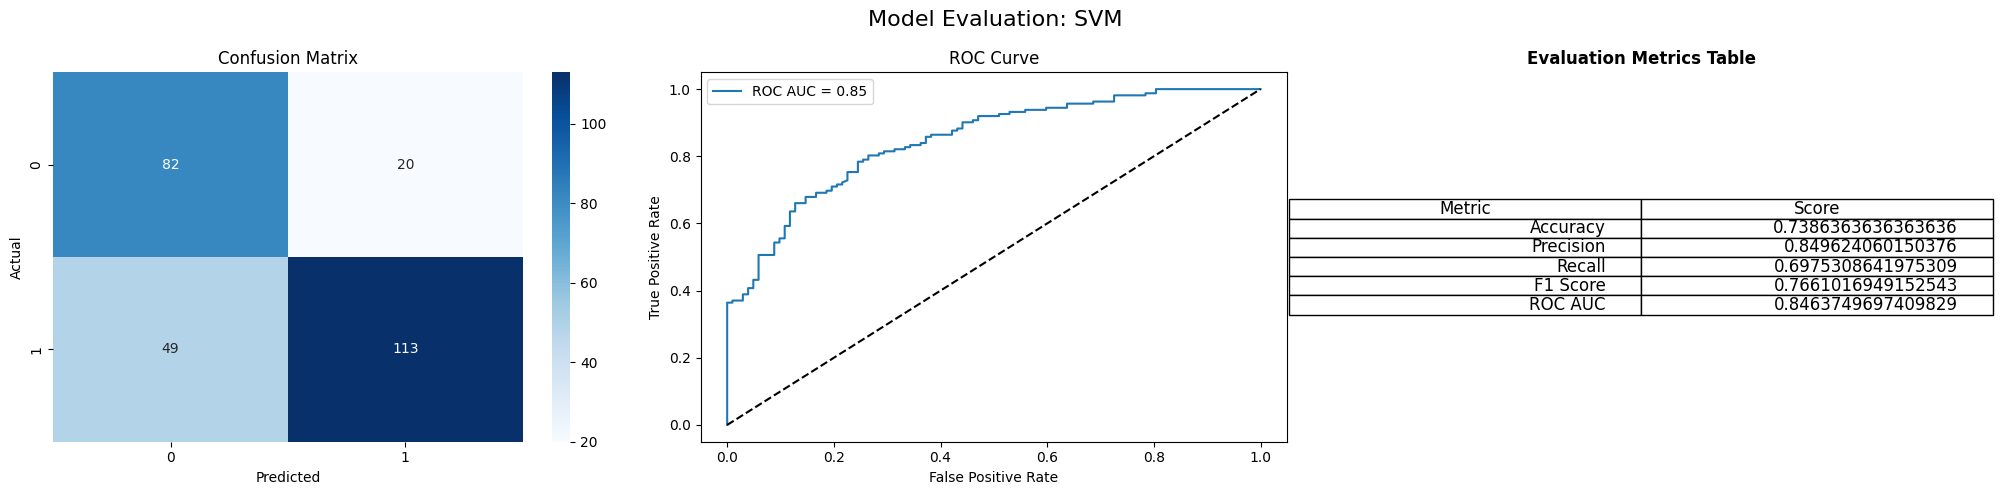

In [12]:
# Create pipeline: StandardScaler + SVM (RBF kernel by default)
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
])

# Train on SMOTE-balanced data
svm_pipeline.fit(X_train_sm, y_train_sm)

# Evaluate
evaluate_model(svm_pipeline, X_test, y_test, "SVM")


## 6. Hyperparameter Tuning

We now perform hyperparameter tuning using GridSearchCV for our SVC model

### 6.1 Tuning SVC

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for SVM: {'svm__C': 50, 'svm__degree': 3, 'svm__gamma': 1, 'svm__kernel': 'poly'}


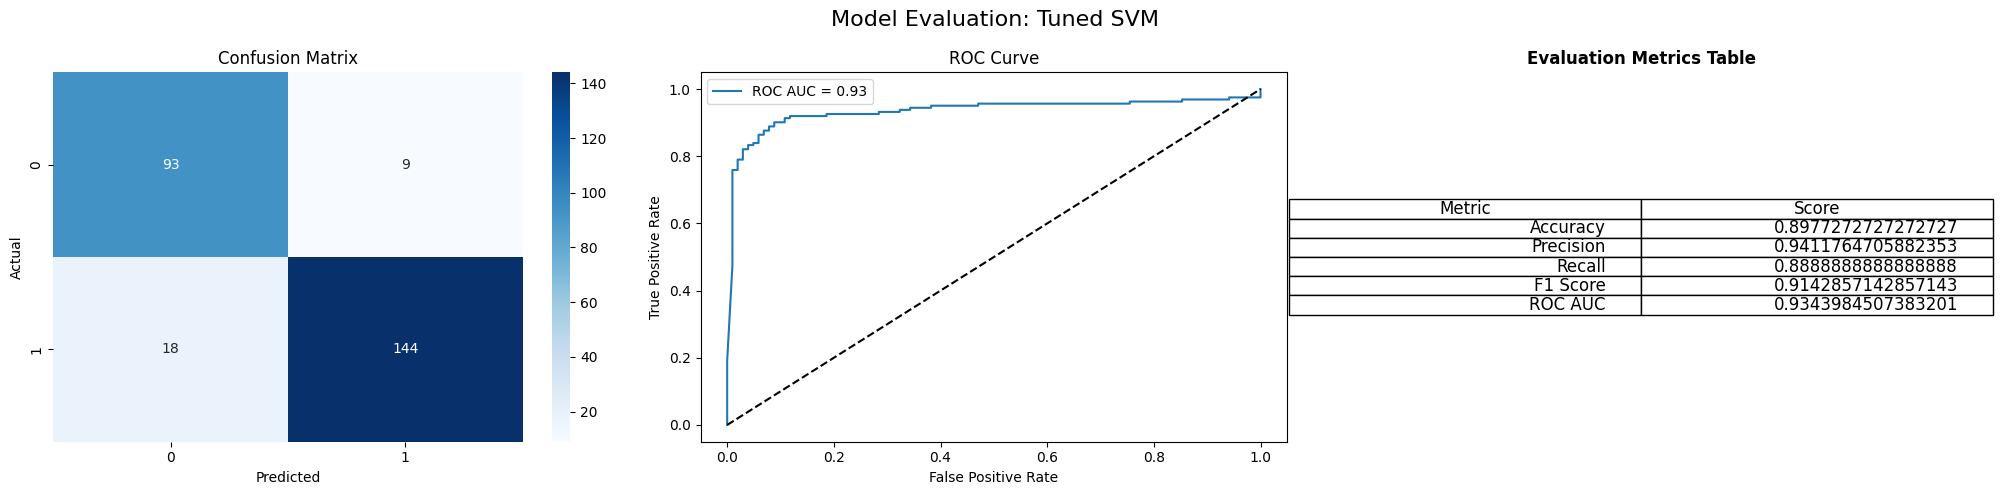

In [13]:
param_grid = {
    'svm__C': [0.1, 1, 10, 50],
    'svm__gamma': ['scale', 0.01, 0.1, 1],
    'svm__kernel': ['rbf', 'poly'], 
    'svm__degree': [2, 3]
}

grid = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train_sm, y_train_sm)

print("Best parameters for SVM:", grid.best_params_)

best_svm = grid.best_estimator_
evaluate_model(best_svm, X_test, y_test, "Tuned SVM")


## 7. Conclusion

In this notebook we:

- Loaded and preprocessed the heart attack dataset.
- Explored the data using visualization and correlation analysis.
- Split the data into training and testing sets using stratification.
- Applied SMOTE to balance the training data.
- Built and evaluated multiple classification models.
- Tuned hyperparameters for SVM.

This workflow not only predicts heart attack risk but also incorporates strategies to handle class imbalance, ensuring robust model performance.